In [1]:
%load_ext cython
import pyrost as rst
# import speckle_tracking as st
from pyrost.bin import *
from pyrost import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
from multiprocessing import cpu_count
from importlib import reload
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb, siunitx}'
plt.rcParams['text.usetex'] = 'True'


pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport.pyximport.PyxImporter at 0x2b3608ab3a50>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'gf', 'ggm', 'make_mll_slice', 'np', 'st', 'st_update']


In [5]:
%time _ = fft_convolve(np.ones((100, 100000)), np.ones(100000), num_threads=1)

CPU times: user 578 ms, sys: 53 ms, total: 631 ms
Wall time: 630 ms


In [3]:
%time out = fft_convolve(np.ones((100, 100000)), np.ones(100000), num_threads=12)

CPU times: user 643 ms, sys: 58.6 ms, total: 701 ms
Wall time: 110 ms


In [20]:
%time det_wfx = fraunhofer_wp(smp_wfx, dx1, dx2, params.det_dist, params.wl, num_threads=64)

CPU times: user 54.4 s, sys: 1.25 s, total: 55.7 s
Wall time: 1.87 s


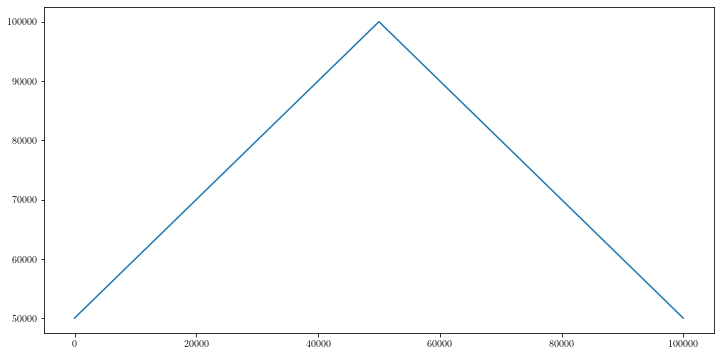

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(out[0])
plt.show()

# Multislice

In [3]:
wl = st_sim.MLL.en_to_wl / 20e3
params = st_sim.MSParams.import_default(x_step=5e-5, z_step=5e-3, n_min=100, n_max=5000,
                                        focus=1.5e3, mll_sigma=5e-5, mll_wl=wl, wl=wl, x_max=30,
                                        mll_depth=5.)
mll = st_sim.MLL.import_params(params)
print(mll.layers.shape)

(999, 4900)


In [4]:
ms_prgt = st_sim.MSPropagator(params, mll)
ms_prgt.beam_propagate()

   0%            Slice 0 / 999 [00:00<?, ?it/s]

In [5]:
det_dist = 2e5
M = det_dist / params.focus * 1.5
wft = ms_prgt.beam_profile[-1]
wft_focus = rsc_wp(wft, params.x_step, 4 * params.x_step, params.focus, params.wl)
wft_far = fraunhofer_wp(wft, params.x_step, M * params.x_step, det_dist, params.wl)

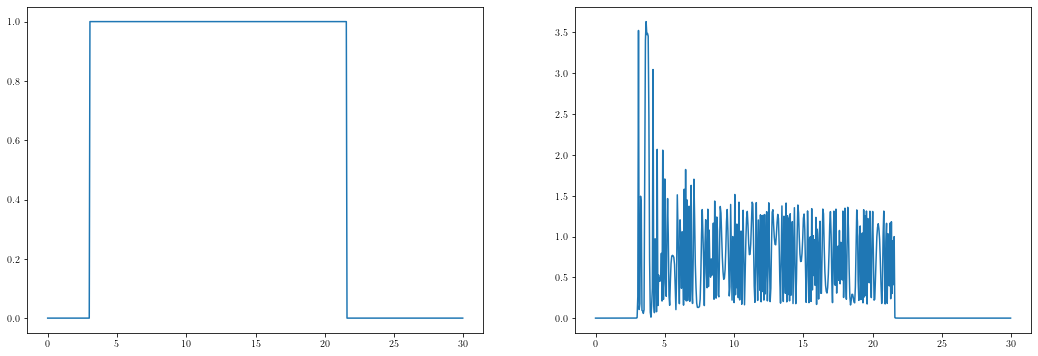

In [6]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(ms_prgt.x_arr[::1000], np.abs(ms_prgt.beam_profile[0, ::1000])**2)
axes[1].plot(ms_prgt.x_arr[::1000], np.abs(ms_prgt.beam_profile[-1, ::1000])**2)
plt.show()

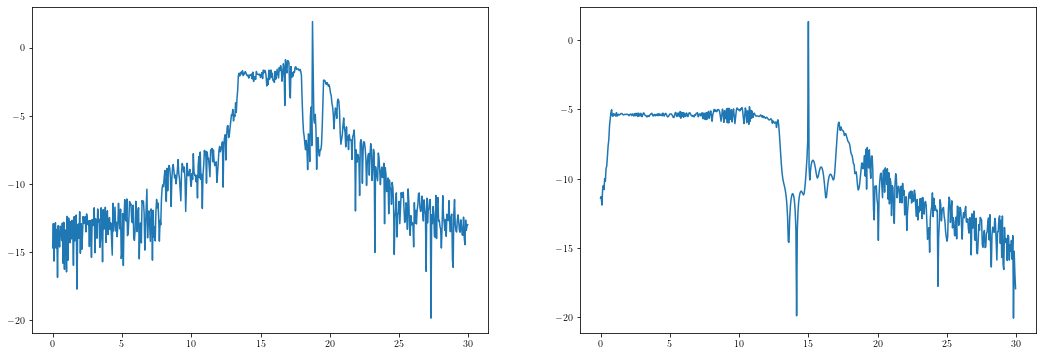

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(ms_prgt.x_arr[::1000], np.log(np.abs(wft_focus[::1000])**2))
axes[1].plot(ms_prgt.x_arr[::1000], np.log(np.abs(wft_far[::1000])**2))
plt.show()

In [5]:
z_arr = np.linspace(0.2 * params.focus, 2. * params.focus)
ds_beam, x_arr = ms_prgt.beam_downstream(z_arr, 4 * params.x_step)

  0%|          | 0/50 [00:00<?, ?it/s]

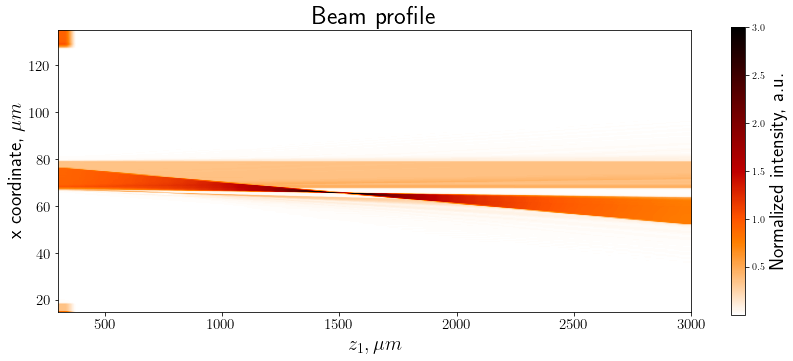

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
im1 = ax.imshow(np.abs(ds_beam.T[::10]), vmax=3., cmap='gist_heat_r',
                extent=[z_arr.min(), z_arr.max(), x_arr.min(), x_arr.max()])
cbar = fig.colorbar(im1, ax=ax, shrink=0.7)
cbar.ax.set_ylabel('Normalized intensity, a.u.', fontsize=20)
ax.set_title('Beam profile', fontsize=25)
ax.set_ylabel(r'x coordinate, $\mu m$', fontsize=20)
ax.set_aspect(10)
ax.tick_params(labelsize=15)
ax.set_xlabel(r'$z_1, \mu m$', fontsize=20)
plt.tight_layout()
# plt.savefig('figures/mll_beam.png', dpi=300)
plt.show()

# Beamtime preparation

In [4]:
log_dir = 'results/log_examples'
log_paths = [os.path.join(log_dir, fname) for fname in os.listdir(log_dir)
             if fname.endswith('.log')]

log_prt = rst.LogProtocol()
log_attrs = log_prt.load_attributes(log_paths[0])
log_data = log_prt.load_data(log_paths[0])

In [3]:
distance = 2.
target = 'Mo'
scan_num = 3092

log_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-logs/Scan_{scan_num:d}.log'
dir_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-frames/Scan_{scan_num:d}'

wl_dict = {'Mo': 7.092917530503447e-11, 'Cu': 1.5498024804150033e-10, 'Rh': 6.137831605603974e-11}

h5_prt = rst.CXIProtocol(default_paths={'data': 'entry/instrument/detector/data',
                                        'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
                                        'y_pixel_size': 'entry/instrument/detector/y_pixel_size'},
                         datatypes={'data': 'float', 'x_pixel_size': 'float',
                                    'y_pixel_size': 'float'})
cxi_prt = rst.CXIProtocol()
log_prt = rst.LogProtocol()
cxi_loader = rst.CXILoader(h5_prt)

ss_vec = np.array([0., -1., 0.])
fs_vec = np.array([-1., 0., 0.])

log_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-logs/Scan_{scan_num:d}.log'
dir_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-frames/Scan_{scan_num:d}'
h5_files = sorted([os.path.join(dir_path, path) for path in os.listdir(dir_path)
                   if path.endswith('Lambda.nxs')])

attrs = cxi_loader.load_attributes(h5_files[0])
log_attrs = log_prt.load_attributes(log_path)
log_data = log_prt.load_data(log_path)

n_steps = next(iter(log_data.values())).shape[0]
data = np.concatenate(list(cxi_loader.load_data(h5_files).values())[:n_steps], axis=-3)
pix_vec = np.tile(np.array([[attrs['x_pixel_size'], attrs['y_pixel_size'], 0]]),
                  (n_steps, 1)) * 1e-6
basis_vectors = np.stack([pix_vec * ss_vec, pix_vec * fs_vec], axis=1)

with np.load(os.path.join('pyrost/data/sigray_mask.npz')) as mask_file:
    mask = np.tile(mask_file['mask'][None], (n_steps, 1, 1))

translations = np.tile([[log_attrs['Session logged attributes']['x_sample'],
                        log_attrs['Session logged attributes']['y_sample'],
                        log_attrs['Session logged attributes']['z_sample']]],
                    (n_steps, 1))
for data_key in log_data:
    if 'X-SAM' in data_key:
        translations[:, 0] = log_data[data_key]
    if 'Y-SAM' in data_key:
        translations[:, 1] = log_data[data_key]

data_obj = rst.STData(basis_vectors=basis_vectors, data=data, distance=distance,
                  translations=translations, wavelength=wl_dict[target],
                  x_pixel_size=attrs['x_pixel_size'] * 1e-6,
                  y_pixel_size=attrs['y_pixel_size'] * 1e-6, protocol=cxi_prt)

In [7]:
data_obj = data_obj.crop_data((0, data.shape[1], 0, 1400))
data_obj = data_obj.update_mask(pmax=99.999)

size = 5
kernel = np.ones(int(size)) / size
mean = data_obj.whitefield.copy()
mean = fft_convolve(mean, kernel, mode='reflect', axis=0)
mean = fft_convolve(mean, kernel, mode='reflect', axis=1)
mean_sq = data_obj.whitefield**2
mean_sq = fft_convolve(mean_sq, kernel, mode='reflect', axis=0)
mean_sq = fft_convolve(mean_sq, kernel, mode='reflect', axis=1)

In [82]:
r_image = mean_sq - mean**2
r_min = np.max(r_image[:, :50])
r_max = np.max(r_image)
r_image = np.clip(r_image, r_min, r_max) - r_min

In [87]:
from scipy.ndimage import label, generate_binary_structure, sum_labels

s = generate_binary_structure(size, size)
labels, num_labels = label(r_image)
fbeam_lbl, db_lbl = np.argsort(sum_labels(r_image, labels, np.arange(num_labels + 1)))[-2:]
ss_arr, fs_arr = np.where(labels == fbeam_lbl)
roi = np.array([ss_arr.min(), ss_arr.max(), fs_arr.min()])

(array([271, 271, 271, ..., 292, 292, 292]),
 array([ 562,  563,  564, ..., 1253, 1254, 1255]))

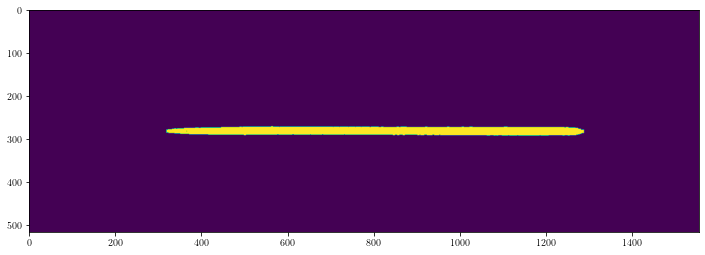

In [84]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(12, 6))
# axes.imshow(data_obj.whitefield, vmax=100)
axes.imshow(labels == fbeam_lbl, vmax=1)
plt.show()

In [88]:
# eiger_dir = "/gpfs/cfel/cxi/scratch/user/jdressel/Beamtime/test data/eiger test data"

scan_num = 51
eiger_dir = f'/asap3/petra3/gpfs/p06/2019/data/11006252/raw/0001_alignment/scan_{scan_num:05d}/eiger4m_01/'

eiger_files = [os.path.join(eiger_dir, fname) for fname in os.listdir(eiger_dir)
               if fname.endswith('.h5') and not fname.endswith('master.h5')]
eiger_master = [os.path.join(eiger_dir, fname) for fname in os.listdir(eiger_dir)
                if fname.endswith('master.h5')][0]
cxi_prt = rst.CXIProtocol(default_paths={'data': 'entry/data/data',
                                         'distance': 'entry/instrument/detector/detector_distance',
                                         'wavelength': 'entry/instrument/beam/incident_wavelength',
                                         'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
                                         'y_pixel_size': 'entry/instrument/detector/y_pixel_size'})

# cxi_loader = rst.CXILoader(cxi_prt)
# shape_dict = cxi_loader.load_data_shape(eiger_files)

# idxs = {}
# for path, shapes in shape_dict.items():
#     if isinstance(shapes, list):
#         idxs[path] = []
#         for shape in shapes:
#             idxs[path].append((slice(0, 2), ))
#     else:
#         idxs[path] = (slice(0, 2), )
    
# data_dict = cxi_loader.load_data(eiger_files, idxs)

In [6]:
distance = 0.15
target = 'Mo'
scan_num = 3043

log_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-logs/Scan_{scan_num:d}.log'
dir_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-frames/Scan_{scan_num:d}'

wl_dict = {'Mo': 7.092917530503447e-11, 'Cu': 1.5498024804150033e-10, 'Rh': 6.137831605603974e-11}
flip_dict={'Yaw-LENSE-UP': False, 'Pitch-LENSE-UP': False,
           'Yaw-LENSE-DOWN': True, 'Pitch-LENSE-DOWN': True}
sum_axis = {'Yaw-LENSE-UP': 0, 'Pitch-LENSE-UP': 1,
            'Yaw-LENSE-DOWN': 0, 'Pitch-LENSE-DOWN': 1}

h5_prt = rst.CXIProtocol(default_paths={'data': 'entry/instrument/detector/data',
                                        'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
                                        'y_pixel_size': 'entry/instrument/detector/y_pixel_size'},
                         datatypes={'data': 'float', 'x_pixel_size': 'float',
                                    'y_pixel_size': 'float'})
cxi_prt = rst.CXIProtocol()
log_prt = rst.LogProtocol()
cxi_loader = rst.CXILoader(h5_prt)

ss_vec = np.array([0., -1., 0.])
fs_vec = np.array([-1., 0., 0.])

log_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-logs/Scan_{scan_num:d}.log'
dir_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-frames/Scan_{scan_num:d}'
h5_files = sorted([os.path.join(dir_path, path) for path in os.listdir(dir_path)
                   if path.endswith('Lambda.nxs')])

attrs = cxi_loader.load_attributes(h5_files[0])
log_attrs = log_prt.load_attributes(log_path)
log_data = log_prt.load_data(log_path)

n_steps = next(iter(log_data.values())).shape[0]
data = np.concatenate(list(cxi_loader.load_data(h5_files).values())[:n_steps], axis=-3)

with np.load(os.path.join('pyrost/data/sigray_mask.npz')) as mask_file:
    mask = np.tile(mask_file['mask'][None], (n_steps, 1, 1))

whitefield = make_whitefield(data, mask, axis=0)
db_coord = np.unravel_index(np.argmax(whitefield), whitefield.shape)

for flip_key in flip_dict:
    if any(flip_key in data_type for data_type in log_data):
        data_type = [data_type for data_type in log_data if flip_key in data_type][0]
        translations = log_data[data_type]
        if sum_axis[flip_key]:
            data = np.sum(data[:, :, db_coord[1] - 10:db_coord[1] + 10], axis=2)
            theta = np.linspace(0, data.shape[1], data.shape[1]) - db_coord[0]
            theta *= 36e-5 * attrs['x_pixel_size'] / (2 * np.pi * distance)
        else:
            data = np.sum(data[:, db_coord[0] - 10:db_coord[0] + 10], axis=1)
            theta = np.linspace(data.shape[1], 0, data.shape[1]) - db_coord[1]
            theta *= 36e-5 * attrs['y_pixel_size'] / (2 * np.pi * distance)
        if flip_dict[flip_key]:
            data = np.flip(data, axis=0)
        break
else:
    raise ValueError('The scan type is not supported')

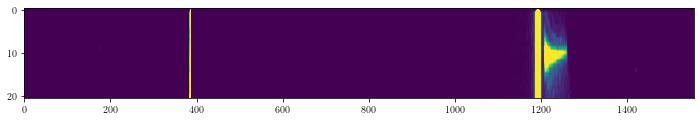

In [7]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data, vmax=100)
ax.set_aspect(10.)
plt.show()

In [10]:
with h5py.File('/gpfs/cfel/cxi/labs/MLL-Sigray/Processed/2021/Scan_3043/Scan_3043_tiltscan.h5', 'r') as cxi_file:
    omega = cxi_file['Omega'][()]
    print(cxi_file['Orientation'][()])

b'h'


# ST Simulation

In [3]:
params = st_sim.STParams.import_default(bar_size=0.7, bar_sigma=0.18, bar_atn=0.2,
                                        bulk_atn=0.1, p0 = 5e4, th_s=8e-5, n_frames=200,
                                        offset=2.0, step_size=0.1, focus=1500, defocus=500,
                                        alpha=0.05, ab_cnt=0.7, bar_rnd=0.7, ap_x=80, ap_y=10, det_dist=1.5e6,
                                        fs_size=2000, ss_size=2000)

globals().update(**params.export_dict())
print(params)

{'exp_geom': {'defocus': 500.0, 'det_dist': 1500000.0, 'n_frames': 200, 'step_size': 0.1, 'step_rnd': 0.2}, 'detector': {'fs_size': 2000, 'pix_size': 55.0, 'ss_size': 2000}, 'source': {'p0': 50000.0, 'th_s': 8e-05, 'wl': 7.29e-05}, 'lens': {'alpha': 0.05, 'ap_x': 80.0, 'ap_y': 10.0, 'focus': 1500.0, 'ab_cnt': 0.7}, 'barcode': {'bar_atn': 0.2, 'bar_rnd': 0.7, 'bar_sigma': 0.18, 'bar_size': 0.7, 'bulk_atn': 0.1, 'offset': 2.0}, 'system': {'seed': 3678197145905163482}}


In [4]:
n_x = params.x_wavefront_size()
n_y = params.y_wavefront_size()
nx_arr = np.arange(-n_x // 2, n_x // 2)
ny_arr = np.arange(-n_y // 2, n_y // 2)
lens_wfx, lens_wfy, dx0, dy0 = params.lens_wavefronts(return_dxdy=True)
print(n_x, n_y)

234110 20118


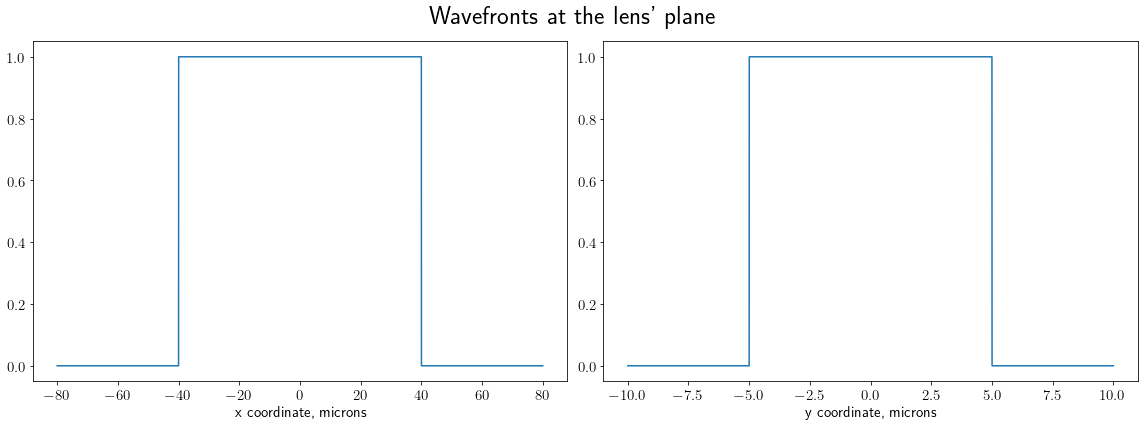

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx0 * nx_arr, np.abs(lens_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy0 * ny_arr, np.abs(lens_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the lens' plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/lens_wf.pdf')

In [5]:
dx1, dy1 = dx0 * params.defocus / params.focus, dy0
z01 = params.focus + params.defocus
%time defoc_wfx = rsc_wp(lens_wfx, dx0, dx1, z01, params.wl, num_threads=1)
%time defoc_wfy = rsc_wp(lens_wfy, dy0, dy1, z01, params.wl, num_threads=12)

CPU times: user 137 ms, sys: 9.67 ms, total: 147 ms
Wall time: 146 ms
CPU times: user 16.1 ms, sys: 271 µs, total: 16.4 ms
Wall time: 16.3 ms


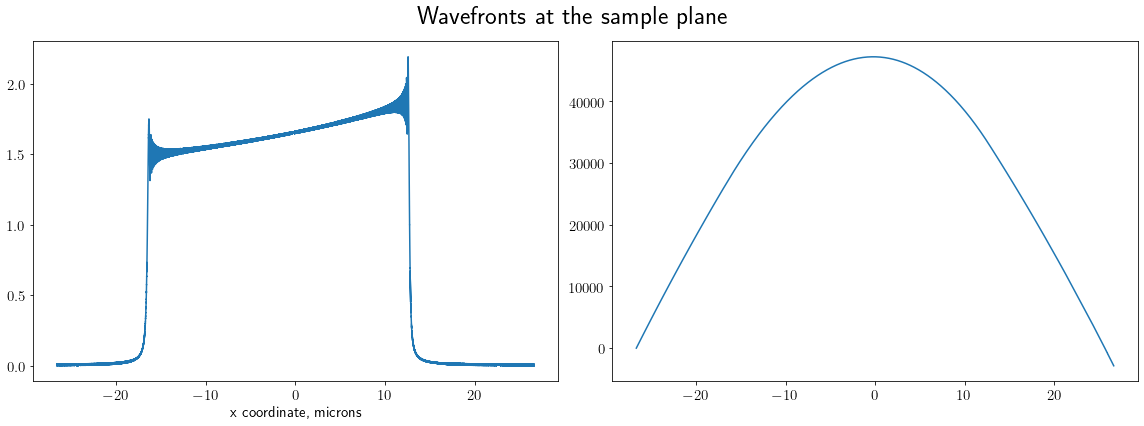

In [13]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx1 * nx_arr, np.abs(defoc_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dx1 * nx_arr, np.unwrap(np.angle(defoc_wfx)))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the sample plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/sample_wf.pdf')

In [6]:
x0, x1 = params.beam_span(params.defocus)
x1 += params.step_size * params.n_frames
bar_pos = bar_positions(x0 + params.offset, x1 - params.offset, params.bar_size, params.bar_rnd, 0)

In [7]:
smp_pos = params.sample_positions()
x_arr = dx1 * nx_arr + smp_pos[:, None]
%time b_tr = barcode_profile(x_arr=x_arr, bars=bar_pos, bulk_atn=params.bulk_atn, \
                             bar_atn=params.bar_atn, bar_sigma=params.bar_sigma, \
                             num_threads=32)
smp_wfx = defoc_wfx * b_tr

CPU times: user 8.6 s, sys: 226 ms, total: 8.83 s
Wall time: 450 ms


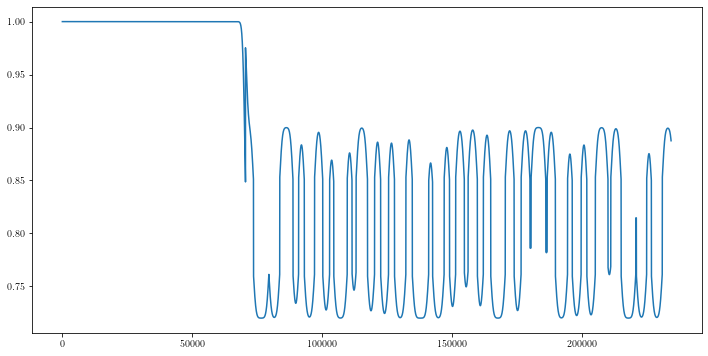

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.abs(b_tr[10]))
plt.show()

In [8]:
dx2, dy2 = params.fs_size * params.pix_size / n_x, params.ss_size * params.pix_size / n_y
%time det_wfx = fraunhofer_wp(smp_wfx, dx1, dx2, params.det_dist, params.wl, num_threads=64)
%time det_wfy = fraunhofer_wp(defoc_wfy, dy1, dy2, params.det_dist, params.wl, num_threads=64)
print(smp_wfx.shape, det_wfx.shape)

CPU times: user 59.4 s, sys: 2.95 s, total: 1min 2s
Wall time: 1.49 s
CPU times: user 12.9 ms, sys: 632 µs, total: 13.5 ms
Wall time: 12.8 ms
(200, 234110) (200, 234110)


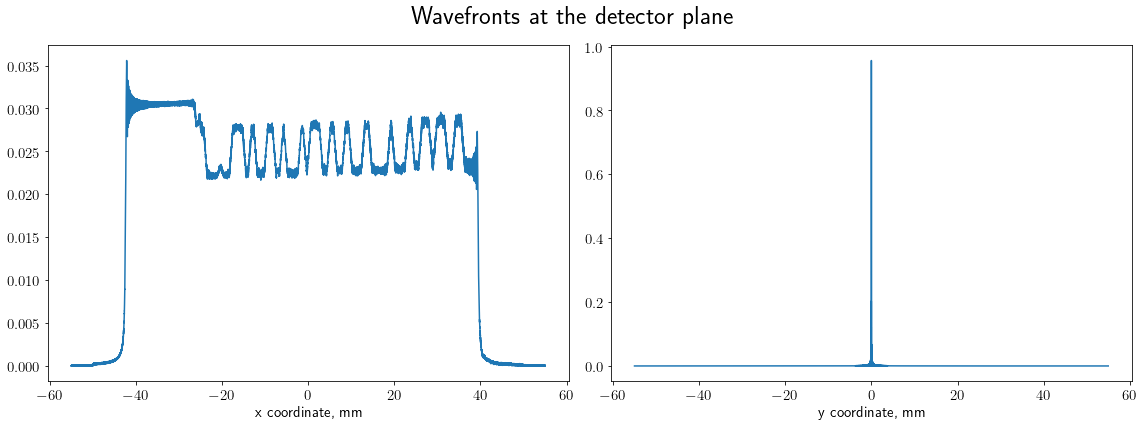

In [9]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.abs(det_wfx[2]))
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.abs(det_wfy))
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_wf.pdf')

In [69]:
sc_x = params.source_curve(params.defocus + params.det_dist, dx2)
sc_y = params.source_curve(params.defocus + params.det_dist, dy2)
pfx = np.sqrt(params.p0) / params.ap_x * np.abs(det_wfx)**2
pfy = np.sqrt(params.p0) / params.ap_y * np.abs(det_wfy)**2
print(pfx.shape, sc_x.shape)
%time det_ix = fft_convolve(pfx, sc_x, num_threads=32)
%time det_iy = fft_convolve(pfy, sc_y, num_threads=32)
# print(det_ix.shape, det_iy.shape)

(200, 234110) (2043,)
CPU times: user 13.1 s, sys: 302 ms, total: 13.4 s
Wall time: 665 ms
CPU times: user 1.75 ms, sys: 72 µs, total: 1.83 ms
Wall time: 1.76 ms


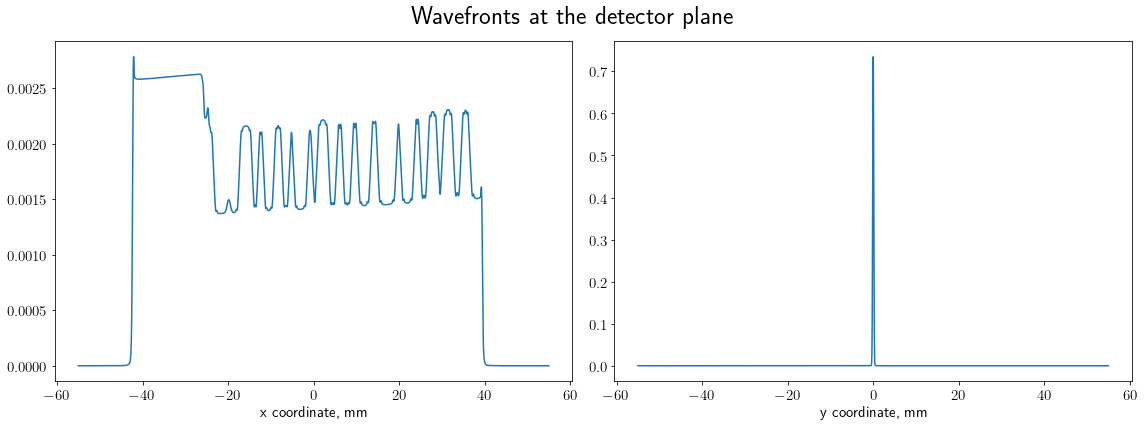

In [70]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, det_ix[0])
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, det_iy)
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_int.pdf')

In [106]:
wfx = np.ones(params.fs_size)
wfy = np.ones(params.ss_size)
%time frames = make_frames(pfx=det_ix, pfy=det_iy, dx=dx2, dy=dy2, \
                           shape=(params.ss_size, params.fs_size), \
                           seed=-1, num_threads=16)
%time wfield = make_whitefield(frames, np.ones(frames.shape, dtype=bool), 0, 16)
frames.shape, wfield.shape

CPU times: user 9.43 s, sys: 1.76 s, total: 11.2 s
Wall time: 845 ms
CPU times: user 25.1 s, sys: 181 ms, total: 25.3 s
Wall time: 1.95 s


((200, 2000, 2000), (2000, 2000))

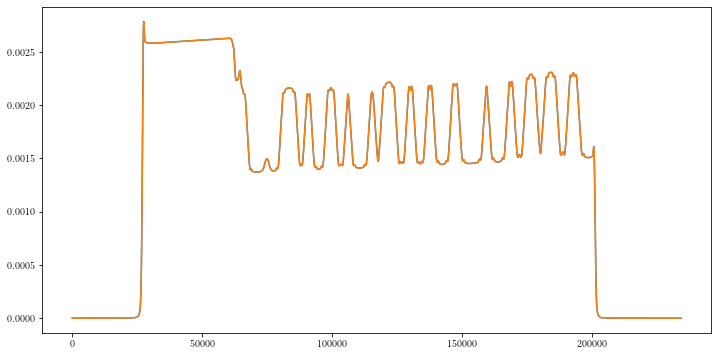

In [111]:
from scipy.interpolate import interp1d

x = np.arange(pfx.shape[1])
x_new = np.linspace(0, pfx.shape[1] - 1, params.fs_size)


%matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot(x, det_ix[0])
axes.plot(x_new, interp1d(x, det_ix[0])(x_new))
plt.show()

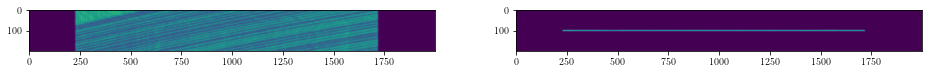

In [78]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(frames.sum(axis=1))
axes[1].imshow(wfield[(params.ss_size // 2 - 100):(params.ss_size // 2 + 100), :])
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [4]:
params = st_sim.STParams.import_default(bar_size=0.7, bar_sigma=0.18, bar_atn=0.18,
                                        bulk_atn=0.15, rnd_dev=0.7, p0=5e4, th_s=1.5e-4,
                                        n_frames=200, defocus=40, alpha=0.04, ab_cnt=0.7,
                                        step_size=0.15, step_rnd=0.8, seed=8457259)
st_conv = st_sim.STConverter()
sim_obj = st_sim.STSim(params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

In [113]:
grad, sweep = data.defocus_sweep(np.linspace(20e-6, 100e-6, 20))

Generating defocus sweep:   0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
st_obj = data.get_st()

st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

   0%            Iteration 0 / 30 [00:00<?, ?it/s]

Initial MSE = 0.218514, Initial ls_ri = 8.00


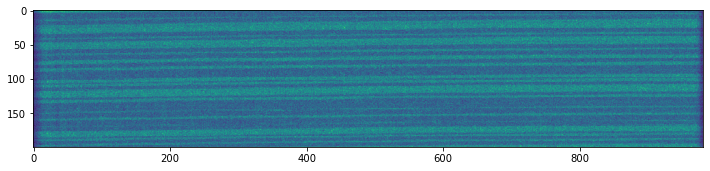

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

In [7]:
params = st_sim.STParams.import_default(bar_size=0.25, bar_sigma=0.18, bar_atn=0.22,
                                        bulk_atn=0.15, bar_rnd=0.7, p0 = 5e4, th_s=8e-5,
                                        n_frames=200, defocus=30, alpha=0.03,
                                        ab_cnt=0.7)

st_conv = st_sim.STConverter()

In [43]:
sim_obj = st_sim.STSim(params=params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

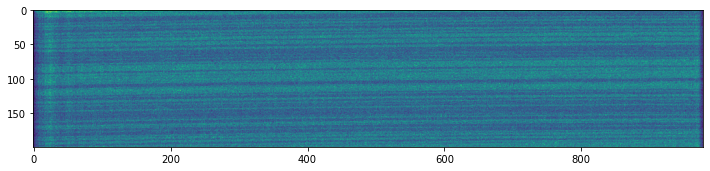

In [44]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

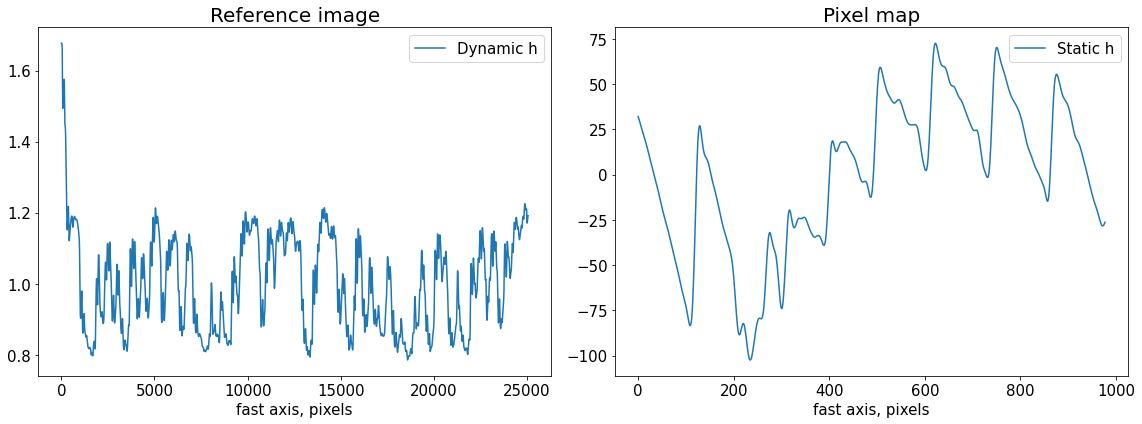

In [46]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(obj.reference_image[0], label='Dynamic h')
axes[1].plot((obj.pixel_map - st_obj.pixel_map)[1, 0] - 
             (obj.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [41]:
st_obj = data.get_st(num_threads=16)
st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

Initial MSE = 0.440567, Initial ls_ri = 8.00
Iteration No. 1: Total MSE = 0.400667, ls_ri = 10.88
Iteration No. 2: Total MSE = 0.351141, ls_ri = 14.91
Iteration No. 3: Total MSE = 0.309532, ls_ri = 18.93
Iteration No. 4: Total MSE = 0.283405, ls_ri = 21.69
Iteration No. 5: Total MSE = 0.269093, ls_ri = 23.24
Iteration No. 6: Total MSE = 0.260826, ls_ri = 24.06
Iteration No. 7: Total MSE = 0.256253, ls_ri = 24.50
Iteration No. 8: Total MSE = 0.253984, ls_ri = 24.78
Iteration No. 9: Total MSE = 0.250753, ls_ri = 25.04
Iteration No. 10: Total MSE = 0.248626, ls_ri = 25.29
Iteration No. 11: Total MSE = 0.245684, ls_ri = 25.53
Iteration No. 12: Total MSE = 0.243465, ls_ri = 25.80
Iteration No. 13: Total MSE = 0.242260, ls_ri = 25.93
Iteration No. 14: Total MSE = 0.240375, ls_ri = 26.16
Iteration No. 15: Total MSE = 0.239756, ls_ri = 26.21
Iteration No. 16: Total MSE = 0.239550, ls_ri = 26.19
Iteration No. 17: Total MSE = 0.239581, ls_ri = 26.14


In [27]:
data = data.update_phase(st_res)
fit_obj = data.get_fit()
fit_obj.defocus = np.abs(fit_obj.defocus)
fit = fit_obj.fit()
ph_fit = fit_obj.fit_phase()

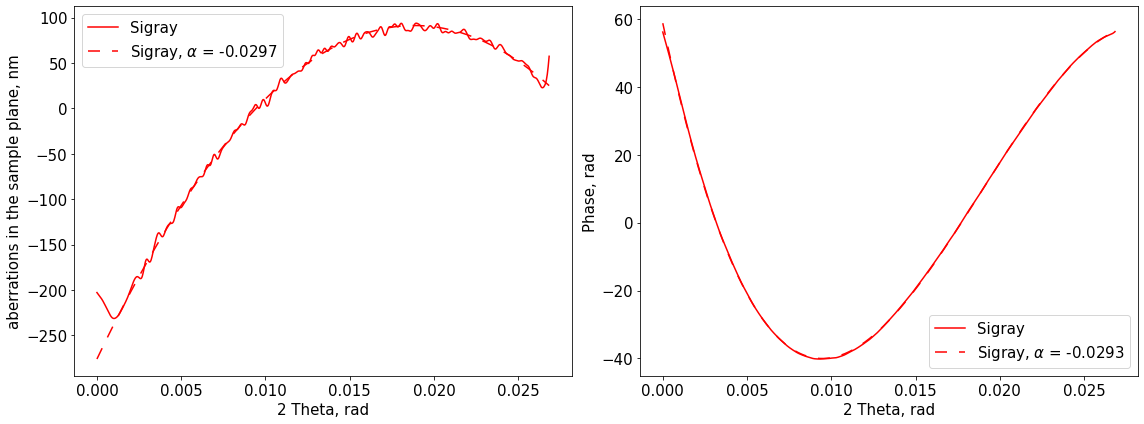

In [28]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.pixel_aberrations * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('aberrations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap, fit_obj.model(ph_fit['ph_fit']), 
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(ph_fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[1].set_ylabel('Phase, rad', fontsize=15)
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

# Experimental results

In [5]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220), 2557: (0, 1, 150, 1000),
            2797: (0, 1, 310, 1240), 2804: (0, 1, 180, 1220), 2894: (0, 1, 260, 1230), 2924: (0, 1, 250, 1200),
            2934: (0, 1, 320, 1240), 2936: (0, 1, 40, 1250), 2989: (0, 1, 200, 1245), 3029: (0, 1, 550, 1210)}

scan_num = 3121

data = rst.cxi_converter_sigray(scan_num)


# data_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/Processed/2021/Scan_{scan_num:d}/Scan_{scan_num:d}.cxi'
# loader = rst.CXILoader()
# data_2 = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num])
# data_2 = data_2.update_defocus(1e-4)

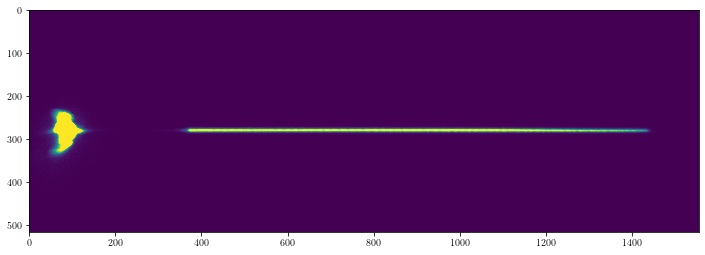

In [6]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(data.data[0] * data.mask[0], vmax=100)
plt.show()

In [28]:
# data = data.update_mask(pmax=99.999, update='multiply')
data = data.integrate_data(axis=0)
# data = data.mirror_data(axis=1)
data = data.crop_data((0, 1, 380, 1430))

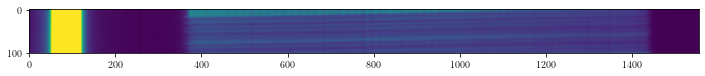

In [29]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(data.data[:, 0], vmax=2000)
# ax.imshow(data.get('data')[:, 0], vmax=1000)
plt.show()

In [30]:
defoci = np.linspace(5e-5, 3e-4, 100)
ds_scan, extra = data.defocus_sweep(defoci, size=101, ls_ri=50, return_extra=True)

Generating defocus sweep:   0%|          | 0/100 [00:00<?, ?it/s]

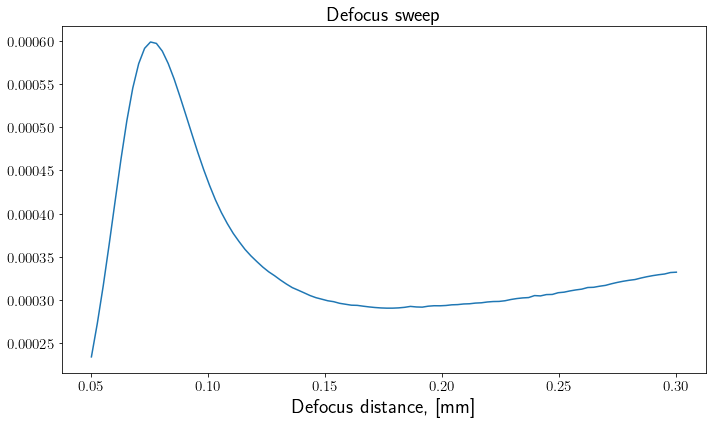

In [31]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
ax.set_title('Defocus sweep', fontsize=20)
ax.set_xlabel('Defocus distance, [mm]', fontsize=20)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

In [32]:
data = data.update_defocus(defocus_fs=defoci[np.argmax(ds_scan)])

st_obj = data.get_st()

st_rgd = st_obj.iter_update_gd(ls_ri=16., ls_pm=1.5, blur=14., sw_fs=3, n_iter=150,
                               learning_rate=5e0, verbose=True)

   0%            Iteration 0 / 150 [00:00<?, ?it/s]

Initial MSE = 0.060180, Initial ls_ri = 16.00


In [33]:
data = data.update_phase(st_rgd)
fit_obj = data.get_fit()

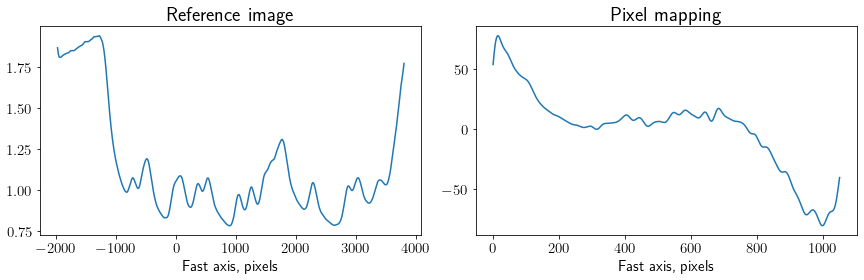

In [34]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(np.arange(st_rgd.reference_image.shape[1]) - st_rgd.m0,
             st_rgd.reference_image[0])
axes[1].plot(data.get('pixel_aberrations')[1, 0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel mapping', fontsize=20)
for ax in axes:
    ax.set_xlabel('Fast axis, pixels', fontsize=15)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

In [37]:
center = 20
fit_rst = data.get_fit(center=center).remove_linear_term()
fit_rst = fit_rst.crop_data([10, fit_rst.pixels.size - 30])
fcf_rst = fit_rst.fit(max_order=3, loss='linear')

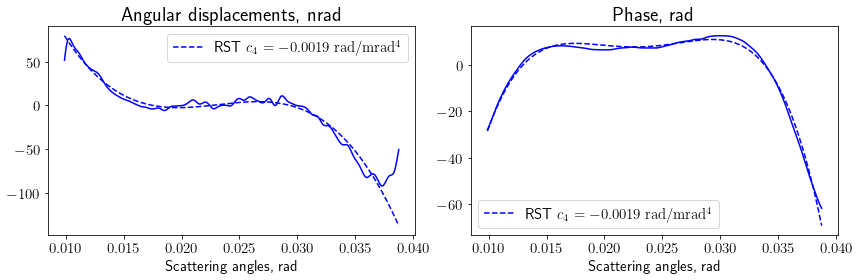

In [38]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(fit_rst.thetas, fit_rst.theta_aberrations * 1e9, 'b')
axes[0].plot(fit_rst.thetas, fit_rst.model(fcf_rst['fit']) * fit_rst.ref_ap * 1e9, 'b--',
             label=fr"RST $c_4 = {fcf_rst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[0].set_title('Angular displacements, nrad', fontsize=20)

axes[1].plot(fit_rst.thetas, fit_rst.phase, 'b')
axes[1].plot(fit_rst.thetas, fit_rst.model(fcf_rst['ph_fit']), 'b--',
             label=fr"RST $c_4={fcf_rst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[1].set_title('Phase, rad', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Scattering angles, rad', fontsize=15)
plt.tight_layout()
plt.show()

In [3]:
data_path = '/gpfs/cfel/cxi/data/2019/NSLS-2019_Bajt-Sep/cxifiles/scan_81763/scan_81763.cxi'
loader = rst.CXILoader()
data_nsls = loader.load(data_path, roi=(0, 300, 200, 519))
data_nsls = data_nsls.update_mask(method='perc-bad', pmax=99.995)

In [4]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
gb_images = []
ls_low = 1.
ls_high = 10.
for defocus in tqdm(df_nsls, total=len(df_nsls), desc='Generating defocus sweep'):
    st_obj = data_nsls.update_defocus(defocus).get_st().update_reference(ls_ri=1.5)
    grad_ss_high = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_low, 1),
                                axis=0, mode='reflect', num_threads=st_obj.num_threads)
    grad_ss_low = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_high, 1),
                               axis=0, mode='reflect', num_threads=st_obj.num_threads)
    grad_fs_high = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_low, 1),
                                axis=1, mode='reflect', num_threads=st_obj.num_threads)
    grad_fs_low = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_high, 1),
                               axis=1, mode='reflect', num_threads=st_obj.num_threads)
    mean_med = gaussian_filter(st_obj.reference_image, (ls_low + ls_high) / 2, mode='reflect',
                               num_threads=st_obj.num_threads)
    gb_image = ((grad_ss_high - grad_ss_low)**2 + (grad_fs_high - grad_fs_low)**2) / mean_med**2
    gb_images.append(gb_image)

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

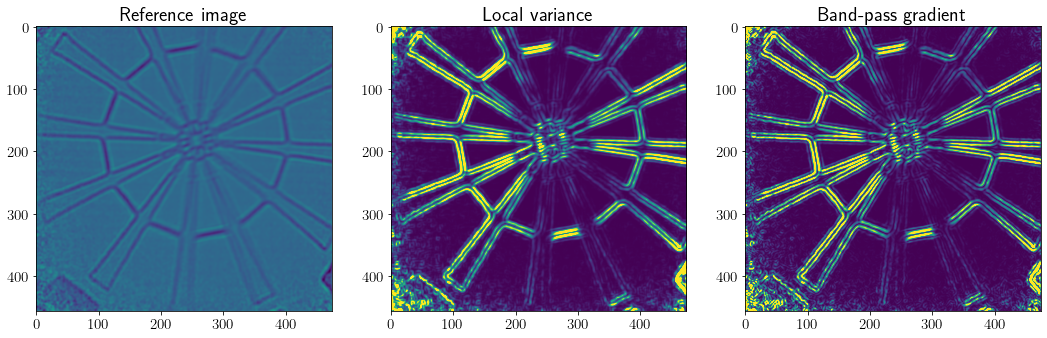

In [23]:
%matplotlib inline
idx = 15
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes[0].imshow(extra['reference_image'][idx], vmax=1.5)
axes[0].set_title('Reference image', fontsize=20)
axes[1].imshow(extra['r_image'][idx], vmax=2e-3)
axes[1].set_title('Local variance', fontsize=20)
axes[2].imshow(gb_images[idx], vmax=1e-3)
axes[2].set_title('Band-pass gradient', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.show()

In [6]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
dss_nsls, extra = data_nsls.defocus_sweep(df_nsls, size=5., ls_ri=1.1, return_extra=True)

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
gb_vals = np.array([np.mean(gb_image) for gb_image in gb_images])

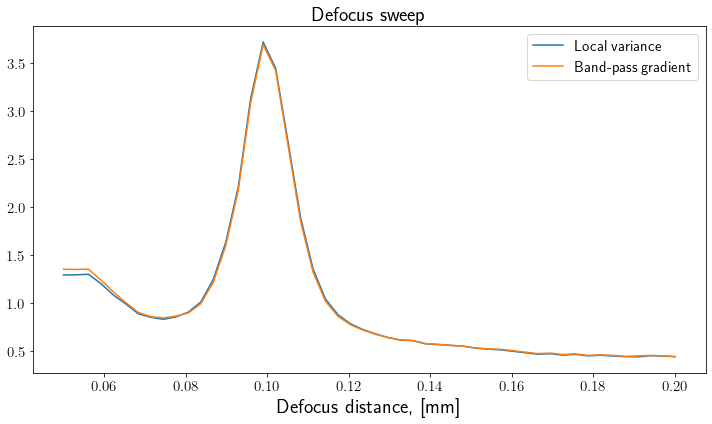

In [19]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_nsls * 1e3, dss_nsls / np.mean(dss_nsls), label='Local variance')
ax.plot(df_nsls * 1e3, gb_vals / np.mean(gb_vals), label='Band-pass gradient')
ax.set_title('Defocus sweep', fontsize=20)
ax.set_xlabel('Defocus distance, [mm]', fontsize=20)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [21]:
data_nsls = data_nsls.update_defocus(defocus_fs=df_nsls[np.argmax(dss_nsls)])

st_obj_nsls = data_nsls.get_st()
st_obj_nsls = st_obj_nsls.update_reference(sw_ss=0, sw_fs=0, ls_ri=1.5)

st_rgd_nsls = st_obj_nsls.iter_update_gd(ls_ri=1.1, ls_pm=1.1, blur=6., sw_fs=3, sw_ss=3,
                                         n_iter=20, verbose=True, learning_rate=0.1)

   0%            Iteration 0 / 20 [00:00<?, ?it/s]

Initial MSE = 0.760687, Initial ls_ri = 1.10


In [22]:
data_nsls = data_nsls.update_phase(st_rgd_nsls)
fit_obj_nsls = data_nsls.get_fit(axis=0)

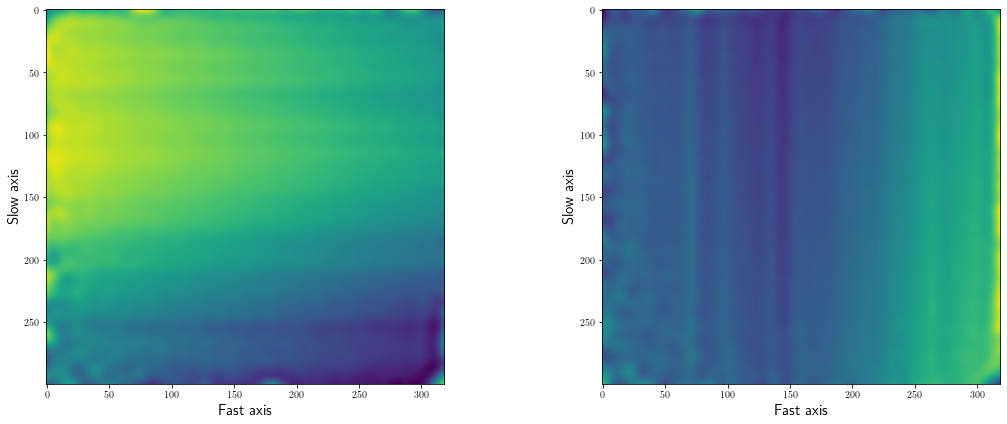

In [23]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0])
axes[1].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[1])
for ax in axes:
    ax.set_xlabel('Fast axis', fontsize=15)
    ax.set_ylabel('Slow axis', fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('nsls_pix_aberrations.pdf')

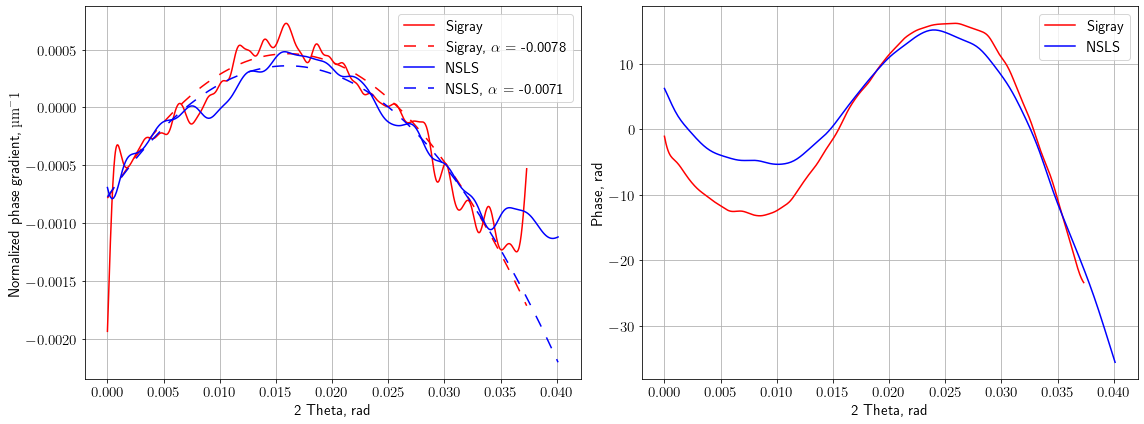

In [29]:
fit_obj = data.get_fit(center=150)
fit_obj = fit_obj.remove_linear_term()
fit_obj_nsls = fit_obj_nsls.crop_data([10, 240]).remove_linear_term()
fit_nsls = fit_obj_nsls.fit()
fit = fit_obj.crop_data([10, 650]).fit()

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.thetas, fit_obj.pixel_aberrations * fit_obj.defocus / fit_obj.distance,
             label='Sigray', c='r')
axes[0].plot(fit_obj.thetas, fit_obj.model(fit['fit']) * fit_obj.defocus / fit_obj.distance,
             label=fr"Sigray, $\alpha$ = {fit['c_3']:.4f}",
             c='r', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj.thetas, fit_obj.phase, label='Sigray', c='r')

axes[0].plot(fit_obj_nsls.thetas,
             fit_obj_nsls.pixel_aberrations * fit_obj_nsls.defocus / fit_obj_nsls.distance,
             label='NSLS', c='b')
axes[0].plot(fit_obj_nsls.thetas,
             fit_obj_nsls.model(fit_nsls['fit']) * fit_obj_nsls.defocus / fit_obj_nsls.distance,
             label=fr"NSLS, $\alpha$ = {fit_nsls['c_3']:.4f}",
             c='b', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj_nsls.thetas, fit_obj_nsls.phase, label='NSLS', c='b')

axes[0].set_ylabel('Normalized phase gradient, \si{\micro\metre^-1}', fontsize=15)
axes[1].set_ylabel('Phase, rad', fontsize=15)
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
    ax.grid(True)
plt.tight_layout()
# plt.savefig('figures/nsls_sigray_comp.pdf')
plt.show()